In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import parameters

In [7]:
mu = 0.05
kappa = 0.1
sigma = 0.01
r0 = 0.05
n_scenarios = 250
dt = 0.25
T = 10
l_scenarios = int(T / dt)
tau_T = 10
dtau = 0.25
SwapRate = 0.05
scenarios_tau_length = int(tau_T / dtau)
alpha = 0.95

# Apple vasicek model simulate interest rate evolution and modeling bond price

In [8]:
def B(kappa, tau):
    return (1 - np.exp(-kappa * tau)) / kappa


def A(kappa, mu, sigma, tau):
    B_val = B(kappa, tau)
    kappa2 = kappa * kappa
    sigma2 = sigma * sigma
    term1 = (B_val - tau) * (kappa2*mu - sigma2/2) / kappa2
    term2 = (sigma2 * B_val**2) / (4 * kappa)
    return np.exp(term1 - term2)


def current_bond_price(curr_short_rate, curr_z_prices):
    for i in range(0, l_scenarios):
        tau = (i + 1) * dt
        curr_z_prices[i] = np.exp(-B(kappa, tau) * curr_short_rate) * A(kappa, mu, sigma, tau)

In [14]:
def vasicek_model(n_scenarios, l_scenarios, scenarios_tau_length, r0, kappa, mu, dt, sigma):
    short_rates = np.zeros((n_scenarios, l_scenarios + 1))  # Creating an array for short rates
    z_prices = np.zeros((n_scenarios, l_scenarios + 1, scenarios_tau_length))  # Creating an array for zero coupon prices

    for n in range(0, n_scenarios):
        # Dealing with tau=0: The same initial value for all scenarios
        short_rates[n, 0] = r0
        curr_short_rate = short_rates[n, 0]
        curr_z_prices = np.zeros(scenarios_tau_length)
        current_bond_price(curr_short_rate, curr_z_prices)
        for i in range(0, scenarios_tau_length):
            z_prices[n, 0, i] = curr_z_prices[i]
        for j in range(1, l_scenarios + 1):
            short_rates[n,  j] = kappa*(mu - short_rates[n, j-1])*dt + sigma * np.random.randn() * np.sqrt(dt) + short_rates[n, j-1]
            curr_short_rate = short_rates[n, j]
            curr_z_prices = np.zeros(scenarios_tau_length)
            current_bond_price(curr_short_rate, curr_z_prices)
            for i in range(0, scenarios_tau_length):
                z_prices[n, j, i] = curr_z_prices[i]
    return short_rates, z_prices
short_rates_, z_prices_ = vasicek_model(n_scenarios, l_scenarios, scenarios_tau_length, r0, kappa, mu, dt, sigma)

C:\Users\Sirui\AppData\Local\Temp\ipykernel_26116\2304436006.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), label="Scenario Index")


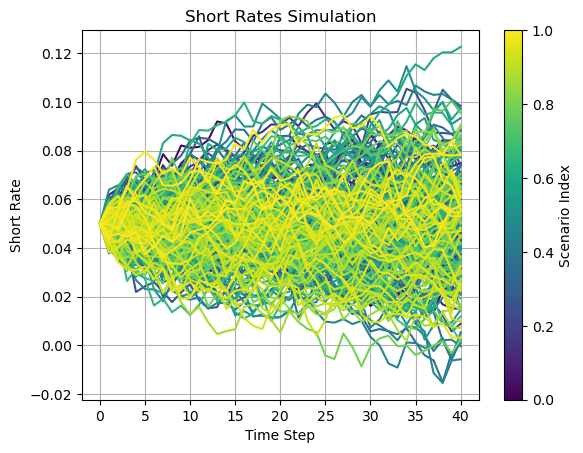

In [17]:
# Plot Short Rates using viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, n_scenarios))
for n in range(n_scenarios):
    plt.plot(short_rates_[n, :], color=colors[n])
plt.title('Short Rates Simulation')
plt.xlabel('Time Step')
plt.ylabel('Short Rate')
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), label="Scenario Index")
plt.grid(True)
plt.show()


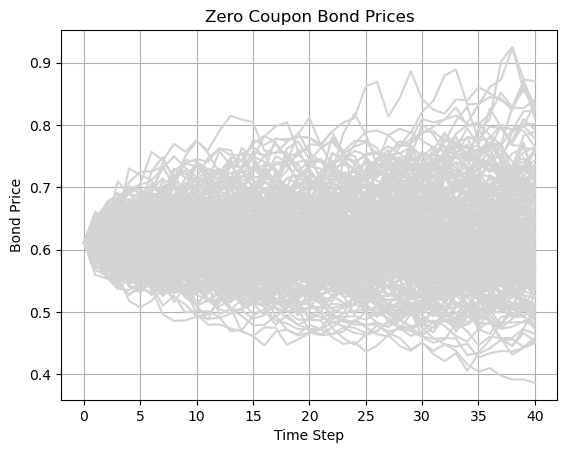

In [18]:
# Plot Zero Coupon Bond Prices
for n in range(n_scenarios):
    plt.plot(z_prices_[n, :, -1], color='lightgrey')
plt.title('Zero Coupon Bond Prices')
plt.xlabel('Time Step')
plt.ylabel('Bond Price')
plt.grid(True)
plt.show()

# Calculate Mark-to-Market value, Expect Exopsure and Potential Future Exposure

In [19]:
def irs_exposure(z_prices, l_scenarios, n_scenarios, SwapRate, alpha):
    IRS_EE = np.zeros(l_scenarios + 1, dtype=float, order='C')  # array for the Expected Exposure values
    IRS_PFE = np.zeros(l_scenarios + 1, dtype=float, order='C')  # array for the PFEk values
    IRS_MtM = np.zeros((n_scenarios, l_scenarios + 1))  # array for MtM values
    SwapFxdLegs = np.zeros((n_scenarios, l_scenarios + 1))
    SwapFltLegs = np.zeros((n_scenarios, l_scenarios + 1))
    for n in range(0, n_scenarios):
        for j in range(0, l_scenarios):
            for i in range(0, scenarios_tau_length - j):
                SwapFxdLegs[n, j] += z_prices[n, j, i]
            SwapFxdLegs[n, j] = dt * SwapRate * SwapFxdLegs[n, j]
            SwapFltLegs[n, j] = 1 - z_prices[n, j, l_scenarios - j - 1]
            IRS_MtM[n, j] = SwapFxdLegs[n, j] - SwapFltLegs[n, j]
        SwapFxdLegs[n, l_scenarios] = 0
        SwapFltLegs[n, l_scenarios] = 0
        IRS_MtM[n, l_scenarios] = 0
    k = int(n_scenarios * alpha)
    print(alpha, k)
    for j in range(0, l_scenarios + 1):
        MtMCurJ = np.zeros(n_scenarios)
        IRS_EE[j] = 0.0
        for n in range(0, n_scenarios):
            MtMCurJ[n] = IRS_MtM[n, j]
            if MtMCurJ[n] > 0:
                IRS_EE[j] = IRS_EE[j] + MtMCurJ[n]
        IRS_EE[j] = IRS_EE[j] / n_scenarios
        MtMCurJsrd = np.sort(MtMCurJ)
        IRS_PFE[j] = MtMCurJsrd[k - 1]
    return IRS_MtM, IRS_EE, IRS_PFE
MtM, EE, PFE = irs_exposure(z_prices_, l_scenarios, n_scenarios, SwapRate, alpha)

0.95 237


In [25]:
MtM_df = pd.DataFrame(MtM)
MtM_df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.003516,-0.023161,-0.022536,-0.018203,-0.005321,0.011246,0.030395,0.034727,0.025592,0.060236,...,0.002189,-0.000025,-0.011816,-0.019252,-0.017437,-0.005417,-0.006151,-0.008592,-0.004393,0.0
1,0.003516,-0.004734,-0.034589,-0.043769,-0.039880,-0.038261,-0.027119,0.000883,0.037193,0.020029,...,0.012298,0.020357,0.023845,0.019102,0.019052,0.013119,0.016557,0.012748,0.006609,0.0
2,0.003516,-0.028300,-0.018681,-0.010250,0.005442,0.014861,0.024327,0.028560,0.006907,0.050437,...,0.025135,0.028677,0.034168,0.026593,0.026626,0.020164,0.016761,0.010280,0.004415,0.0
3,0.003516,0.027704,0.051198,0.032299,0.048318,0.082192,0.049070,0.041774,0.035108,0.040375,...,0.055522,0.050806,0.047161,0.030370,0.017143,0.010149,0.007772,0.008420,0.003320,0.0
4,0.003516,0.021529,-0.006750,0.000258,0.013395,-0.035123,-0.069940,-0.048144,-0.037624,-0.032338,...,0.061244,0.042994,0.038713,0.040454,0.038330,0.034046,0.026147,0.013001,0.005778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.003516,-0.002185,-0.024773,-0.039232,-0.032964,-0.008530,0.040839,0.069482,0.054188,0.040433,...,0.019464,0.002282,0.010153,0.002716,-0.005266,-0.001073,-0.003407,-0.003645,-0.001238,0.0
246,0.003516,0.040193,-0.026598,-0.066992,-0.119623,-0.132342,-0.116770,-0.091375,-0.099194,-0.085856,...,-0.016039,-0.031383,-0.034363,-0.025615,-0.027945,-0.026584,-0.020592,-0.013908,-0.008448,0.0
247,0.003516,-0.028989,-0.031958,-0.072726,-0.043615,-0.021497,-0.011109,0.002714,0.010156,-0.050191,...,-0.074105,-0.054197,-0.053513,-0.049206,-0.040568,-0.030195,-0.022449,-0.013881,-0.006975,0.0
248,0.003516,0.004639,0.016574,-0.024277,-0.063853,-0.083940,-0.104937,-0.070438,-0.069010,-0.072531,...,-0.007725,-0.015109,-0.015459,-0.016035,-0.023973,-0.025207,-0.019873,-0.008815,-0.003938,0.0


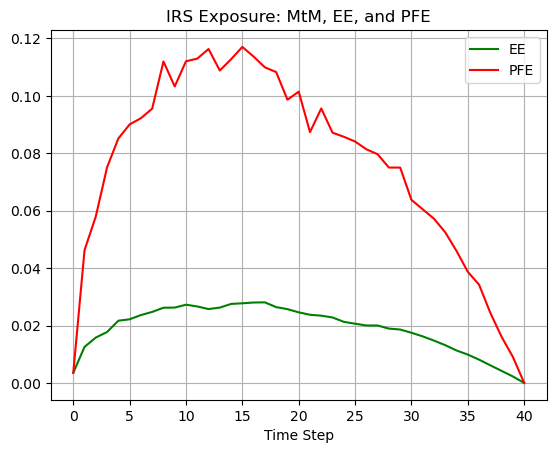

In [26]:
# Plot EE, PFE
plt.plot(EE, label="EE", color="green")
plt.plot(PFE, label="PFE", color="red")
plt.title('IRS Exposure: MtM, EE, and PFE')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True)
plt.show()